In [30]:
# Try to decode which feature was selected per-trial based on firing rates of neurons
# experiment with ranges of firing rates around fixation (selection) time

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches

import pandas as pd
import scipy.stats
from lfp_tools import (
    general as lfp_general,
    startup as lfp_startup,
    development as lfp_development,
    analysis as lfp_analysis
)
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import s3fs
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils
import utils.io_utils as io_utils
from trial_splitters.random_splitter import RandomSplitter
from trial_splitters.block_splitter import BlockSplitter
from models.model_wrapper import ModelWrapper
from models.multinomial_logistic_regressor import (
    MultinomialLogisticRegressor, 
    NormedMultinomialLogisticRegressor,
    NormedDropoutMultinomialLogisticRegressor,
)
from models.value_models import ValueLinearModel, ValueNormedModel
from models.multi_layer import MultiLayer

from models.trainer import Trainer
import pickle

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import plotly.express as px
from itertools import accumulate

import scipy.stats as stats

import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Prep, get merged behavior df

In [31]:
species = 'nhp'
subject = 'SA'
exp = 'WCST'
session = 20180802  # this is the session for which there are spikes at the moment. 


feature_dims = ["Color", "Shape", "Pattern"]

In [32]:
# grab behavioral data, spike data, trial numbers. 
fs = s3fs.S3FileSystem()
behavior_file = spike_general.get_behavior_path(subject, session)
behavior_data = pd.read_csv(fs.open(behavior_file))
valid_beh = behavior_data[behavior_data.Response.isin(["Correct", "Incorrect"])]   
valid_beh = valid_beh[valid_beh.TrialNumber >= 57]

In [33]:
vishwa_states = lfp_development.get_vishwa_states(fs, subject, str(session), behavior_data)

In [34]:
merged = valid_beh.merge(vishwa_states[["trialIndex", "category"]], left_on="TrialNumber", right_on="trialIndex")

### Divide into explore exploit states, sample

In [35]:
explore_trials = merged[merged.category.isin([1, 2])]
exploit_trials = merged[merged.category.isin([5])]

In [36]:
print(len(explore_trials))
print(len(exploit_trials))

225
499


In [37]:
rng = np.random.default_rng()
explore_sampled = explore_trials
exploit_sampled = exploit_trials.sample(len(explore_trials), random_state=rng)

In [38]:
pre_interval = 0
post_interval = 350
interval_size = 50
frs = pd.read_pickle(fs.open(f"l2l.pqz317.scratch/firing_rates_{pre_interval}_crossfixation_{post_interval}_{interval_size}_bins.pickle"))

In [39]:
explore_frs = frs[frs.TrialNumber.isin(explore_sampled.TrialNumber)]
exploit_frs = frs[frs.TrialNumber.isin(exploit_sampled.TrialNumber)]

explore_arr = spike_utils.get_unit_fr_array(exploit_frs, "SpikeCounts")
exploit_arr = spike_utils.get_unit_fr_array(explore_frs, "SpikeCounts")

### Do PCA on explore vs exploit

In [40]:
pca = PCA()
pca.fit(explore_arr.T)
explore_explained_var = pca.explained_variance_ratio_
explore_explained_var_cum = np.cumsum(explore_explained_var)
pca = PCA()
pca.fit(exploit_arr.T)
exploit_explained_var = pca.explained_variance_ratio_
exploit_explained_var_cum = np.cumsum(exploit_explained_var)


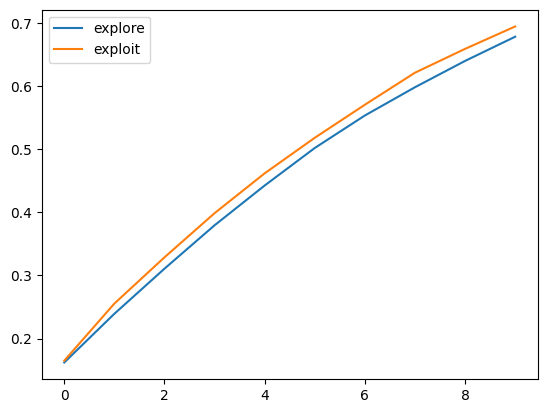

In [41]:
fig, ax = plt.subplots()
ax.plot(explore_explained_var_cum[:10], label="explore")
ax.plot(exploit_explained_var_cum[:10], label="exploit")
ax.legend()

### Plot against randomly shuffled

In [42]:
combined_trials = np.concatenate((explore_sampled.TrialNumber, exploit_sampled.TrialNumber))
rng.shuffle(combined_trials)
group_1_trials = combined_trials[:len(explore_sampled)]
group_2_trials = combined_trials[len(explore_sampled):]

group_1_frs = frs[frs.TrialNumber.isin(group_1_trials)]
group_2_frs = frs[frs.TrialNumber.isin(group_2_trials)]

group_1_arr = spike_utils.get_unit_fr_array(group_1_frs, "SpikeCounts")
group_2_arr = spike_utils.get_unit_fr_array(group_2_frs, "SpikeCounts")

In [43]:
pca = PCA()
pca.fit(group_1_arr.T)
group_1_explained_var = pca.explained_variance_ratio_
group_1_explained_var_cum = np.cumsum(group_1_explained_var)
pca = PCA()
pca.fit(group_2_arr.T)
group_2_explained_var = pca.explained_variance_ratio_
group_2_explained_var_cum = np.cumsum(group_2_explained_var)


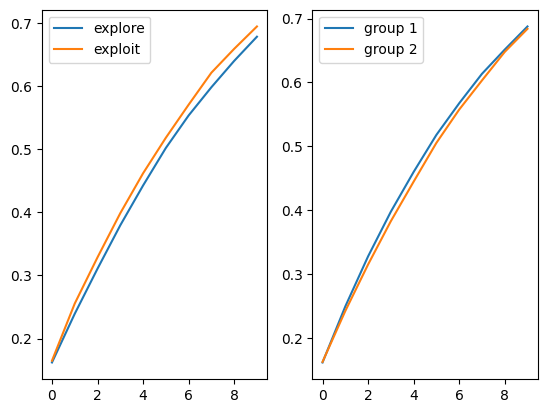

In [44]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(explore_explained_var_cum[:10], label="explore")
ax[0].plot(exploit_explained_var_cum[:10], label="exploit")
ax[0].legend()

ax[1].plot(group_1_explained_var_cum[:10], label="group 1")
ax[1].plot(group_2_explained_var_cum[:10], label="group 2")
ax[1].legend()

### Average across trial first

In [45]:
explore_avg = explore_frs.groupby(by=["TrialNumber", "UnitID"]).mean().reset_index()
exploit_avg = exploit_frs.groupby(by=["TrialNumber", "UnitID"]).mean().reset_index()

explore_arr = spike_utils.get_unit_fr_array(explore_avg, "SpikeCounts")
exploit_arr = spike_utils.get_unit_fr_array(exploit_avg, "SpikeCounts")

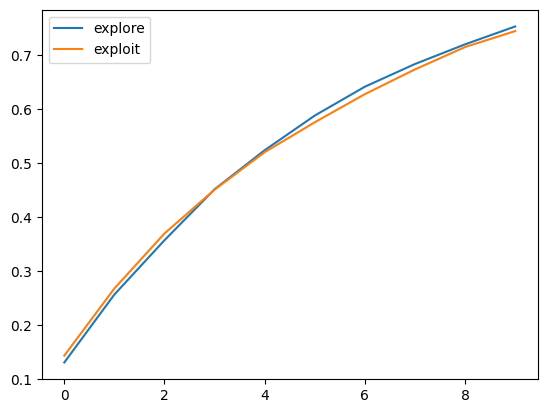

In [46]:
pca = PCA()
pca.fit(explore_arr.T)
explore_explained_var = pca.explained_variance_ratio_
explore_explained_var_cum = np.cumsum(explore_explained_var)
pca = PCA()
pca.fit(exploit_arr.T)
exploit_explained_var = pca.explained_variance_ratio_
exploit_explained_var_cum = np.cumsum(exploit_explained_var)

fig, ax = plt.subplots()
ax.plot(explore_explained_var_cum[:10], label="explore")
ax.plot(exploit_explained_var_cum[:10], label="exploit")
ax.legend()

### What if looking at fb times

In [47]:
pre_interval = 1300
post_interval = 1500
interval_size = 50
fb_frs = pd.read_pickle(fs.open(f"l2l.pqz317.scratch/firing_rates_{pre_interval}_fb_{post_interval}_{interval_size}_bins.pickle"))
fb_frs = fb_frs[(fb_frs.TimeBins >= 1.3) & (fb_frs.TimeBins < 2.3)]

In [48]:
fb_explore_frs = fb_frs[fb_frs.TrialNumber.isin(explore_sampled.TrialNumber)]
fb_exploit_frs = fb_frs[fb_frs.TrialNumber.isin(exploit_sampled.TrialNumber)]

fb_explore_arr = spike_utils.get_unit_fr_array(fb_explore_frs, "FiringRate")
fb_exploit_arr = spike_utils.get_unit_fr_array(fb_exploit_frs, "FiringRate")

In [49]:
pca = PCA()
pca.fit(fb_explore_arr.T)
fb_explore_explained_var = pca.explained_variance_ratio_
fb_explore_explained_var_cum = np.cumsum(fb_explore_explained_var)
pca = PCA()
pca.fit(fb_exploit_arr.T)
fb_exploit_explained_var = pca.explained_variance_ratio_
fb_exploit_explained_var_cum = np.cumsum(fb_exploit_explained_var)

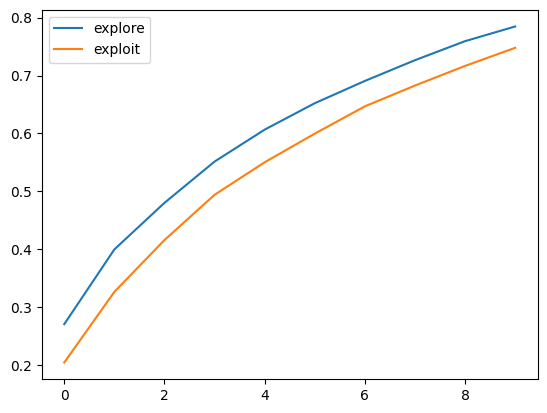

In [50]:
fig, ax = plt.subplots()
ax.plot(fb_explore_explained_var_cum[:10], label="explore")
ax.plot(fb_exploit_explained_var_cum[:10], label="exploit")
ax.legend()

### Conclusion so far: 
Looked at explained variance as a func of # of PCs for cross fixation periods in both explore (category 1, 2) and exploit (category 5 groups), don't see much of a differences

Now want to look at two things:
- In exploit PCA space, are there different average trajectories for different rules? 
- In combined PCA space, are there different average trajectories for explore vs. exploit? 

In [51]:
# get trials where state is in exploit, and got it correct
exploit_cors = merged[(merged.category == 5) & (merged.Response == "Correct")]
explore_cor_frs = frs[frs.TrialNumber.isin(exploit_cors.TrialNumber)]


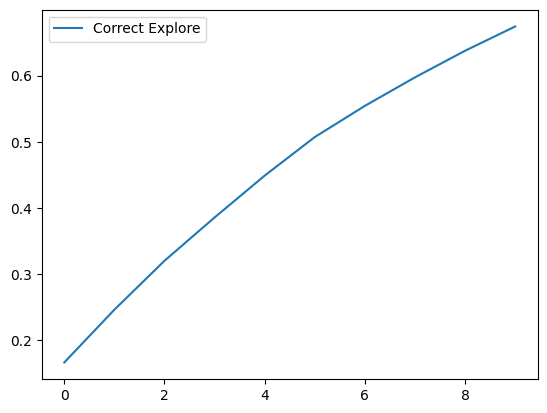

In [92]:
# do PCA on explore cor frs
# plot variance explained
# get top 3 PCs
# for each rule, get firing rates
# project to PC space, average
explore_cor_arr = spike_utils.get_unit_fr_array(explore_cor_frs, "SpikeCounts")

pca = PCA()
pca.fit(explore_cor_arr.T)
explore_core_explained_var = pca.explained_variance_ratio_
explore_cor_explained_var_cum = np.cumsum(explore_core_explained_var)

fig, ax = plt.subplots()
ax.plot(explore_cor_explained_var_cum[:10], label="Correct Explore")
ax.legend()

In [103]:
top_pc_dirs = pca.components_[:2, :].T

In [104]:
top_pc_dirs.shape

(58, 2)

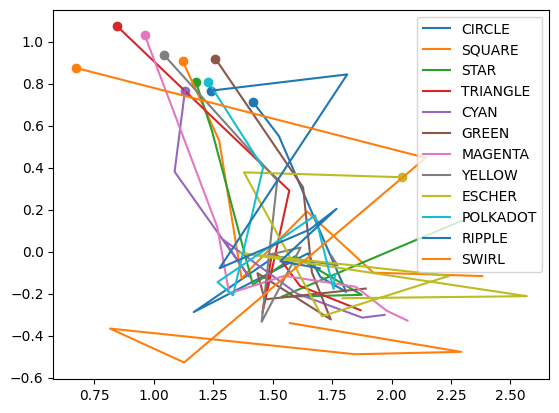

In [114]:
fig, ax = plt.subplots()

for i, rule in enumerate(classifier_utils.FEATURES):
    exploit_cor_rule = exploit_cors[exploit_cors.CurrentRule == rule]
    exploit_cor_rule_fr = frs[frs.TrialNumber.isin(exploit_cor_rule.TrialNumber)]
    explore_cor_rule_arr = spike_utils.get_unit_fr_array(exploit_cor_rule_fr, "SpikeCounts")
    top_pcs = explore_cor_rule_arr.T @ top_pc_dirs
    reshaped = top_pcs.reshape((int(top_pcs.shape[0] / 7), 7, 2))
    means = np.mean(reshaped, axis=0)
    ax.plot(means[:, 0], means[:, 1], label=rule)
    ax.scatter(means[0, 0], means[0, 1], marker="o")
    
ax.legend()


### Can we do the same thing for feedback?

In [115]:
fb_frs = pd.read_pickle(fs.open(f"l2l.pqz317.scratch/firing_rates_{pre_interval}_fb_{post_interval}_{interval_size}_bins.pickle"))
fb_frs = fb_frs[(fb_frs.TimeBins >= 1.3) & (fb_frs.TimeBins < 2.3)]

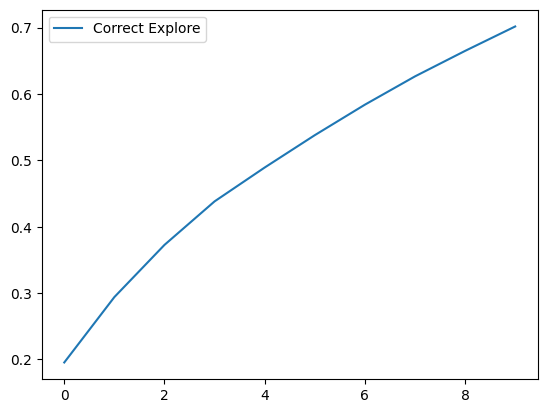

In [116]:
explore_cor_frs = fb_frs[fb_frs.TrialNumber.isin(exploit_cors.TrialNumber)]
# do PCA on explore cor frs
# plot variance explained
# get top 3 PCs
# for each rule, get firing rates
# project to PC space, average
explore_cor_arr = spike_utils.get_unit_fr_array(explore_cor_frs, "SpikeCounts")

pca = PCA()
pca.fit(explore_cor_arr.T)
explore_core_explained_var = pca.explained_variance_ratio_
explore_cor_explained_var_cum = np.cumsum(explore_core_explained_var)

fig, ax = plt.subplots()
ax.plot(explore_cor_explained_var_cum[:10], label="Correct Explore")
ax.legend()

In [118]:
top_pc_dirs = pca.components_[:2, :].T


In [119]:
top_pc_dirs.shape

(59, 2)

In [ ]:
fig, ax = plt.subplots()

for i, rule in enumerate(classifier_utils.FEATURES):
    exploit_cor_rule = exploit_cors[exploit_cors.CurrentRule == rule]
    exploit_cor_rule_fr = fb_frs[fb_frs.TrialNumber.isin(exploit_cor_rule.TrialNumber)]
    explore_cor_rule_arr = spike_utils.get_unit_fr_array(exploit_cor_rule_fr, "SpikeCounts")
    top_pcs = explore_cor_rule_arr.T @ top_pc_dirs
    reshaped = top_pcs.reshape((int(top_pcs.shape[0] / 10), 10, 2))
    means = np.mean(reshaped, axis=0)
    ax.plot(means[:, 0], means[:, 1], label=rule)
    ax.scatter(means[0, 0], means[0, 1], marker="o")
    
ax.legend()
